In [1]:
!pip install boto3==1.15.18
!pip install transformers
!pip install tensorflow_text

In [2]:
import bson
import os
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             precision_recall_fscore_support, 
                             classification_report)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import tensorflow.keras.backend as K
import torch
import random
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import PowerNorm
plt.style.use('seaborn')
import seaborn as sns

## Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open(r'drive/MyDrive/ColabNotebooks/claim_check_worthiness/claims.bson', 'rb') as f:
  claims_json = bson.decode_all(f.read())

In [5]:
def reformat_dataset(raw_data: list=[]) -> pd.DataFrame:
  """ Convert json format to more readable pandas DataFrame
  """
  columns = raw_data[0].keys()
  df = pd.DataFrame(columns=columns)
  for i in range(raw_data.__len__()):
    df.loc[i, :] = raw_data[i]
  return df

In [6]:
claims_df = reformat_dataset(claims_json)

In [7]:
claims_df

,_id,text_es,text_en,text_fr,claim
0,5f80940cf95f926ca81a3751,Gracias.,Thank you.,Merci.,0
1,5f80940cf95f926ca81a3752,"Por ejemplo, cuando estamos hablando de un pa...","For example, when we are talking about a coun...","Par exemple, quand on parle d’un pays qui doi...",0
2,5f80940cf95f926ca81a3753,Entonces como solo creo que es como la políti...,So as I just think it's like the politics of ...,"Donc, comme je pense que c’est comme la polit...",0
3,5f80940cf95f926ca81a3754,Y pienso que el Partido Popular no ha estado ...,And I think the People's Party has not risen ...,Et je pense que le Parti populaire n’a pas ét...,0
4,5f80940cf95f926ca81a3755,Lo siguiente Nos vamos ya volando y les dejo ...,The next thing We fly and I leave you with th...,La prochaine chose que nous volons et je vous...,0
...,...,...,...,...,...
14348,5f80940df95f926ca81a6f5d,Que la agricultura pueda alimentar a los ciud...,That agriculture can feed the citizens.,Que l’agriculture peut nourrir les citoyens.,0
14349,5f80940df95f926ca81a6f5e,Hay que homologar con el resto de países euro...,We have to homologate with the other European...,Nous devons nous homologuer avec les autres p...,0
14350,5f80940df95f926ca81a6f5f,Dicen ustedes del programa inicial del gobier...,Do you say of the coalition government's init...,Dites-vous du programme initial du gouverneme...,0
14351,5f80940df95f926ca81a6f60,Hace falta sentarse las fuerzas políticas que...,We need to sit down the political forces that...,Nous devons asseoir les forces politiques que...,0


## Exploratory Data Analysis

Data seems considerably imbalanced, with really few samples corresponding to *check-worthy claims*

In [15]:
print(f"Verificable claims: {claims_df.loc[claims_df.claim == 1].__len__()} ({np.round(claims_df.loc[claims_df.claim == 1].__len__()/claims_df.__len__(), 4)}%)")

Verificable claims: 1065 (0.0742%)


Check duplicated samples in dataset

In [16]:
any(claims_df.duplicated())

False

In [17]:
claims_df[claims_df.duplicated(subset=['text_es', 'text_en', 'text_fr'])]

,_id,text_es,text_en,text_fr,claim
317,5f80940cf95f926ca81a388e,Buenos días.,Good morning.,Bonjour.,0
347,5f80940cf95f926ca81a38ac,Busque hoy mismo prueba gratuita de WebEx.,Look for WebEx free trial today.,Recherchez l’essai gratuit WebEx dès aujourd’...,0
348,5f80940cf95f926ca81a38ad,Gracias.,Thank you.,Merci.,0
349,5f80940cf95f926ca81a38ae,Por qué?,Why?,Pourquoi?,0
350,5f80940cf95f926ca81a38af,Buenos días.,Good morning.,Bonjour.,0
...,...,...,...,...,...
14201,5f80940df95f926ca81a6eca,Hola buenos días.,Hello good morning.,bonjour bonjour.,0
14231,5f80940df95f926ca81a6ee8,Muchísimas gracias a ustedes.,Thank you very much.,Merci beaucoup.,0
14242,5f80940df95f926ca81a6ef3,Es decir.,I mean.,Je veux dire.,0
14279,5f80940df95f926ca81a6f18,Como bien sabéis hay dos tipos de controles u...,"As you know there are two types of controls, ...","Comme vous le savez, il existe deux types de ...",1


Indeed there are duplicates, not by unique MongoDB id but same text strings repeated multiple times. For example the case shown below:

In [18]:
claims_df.loc[claims_df['text_es'].str.contains('Busque hoy mismo prueba gratuita de WebEx.')]

,_id,text_es,text_en,text_fr,claim
237,5f80940cf95f926ca81a383e,Busque hoy mismo prueba gratuita de WebEx.,Look for WebEx free trial today.,Recherchez l’essai gratuit WebEx dès aujourd’...,0
347,5f80940cf95f926ca81a38ac,Busque hoy mismo prueba gratuita de WebEx.,Look for WebEx free trial today.,Recherchez l’essai gratuit WebEx dès aujourd’...,0


Let's check again the ratio of *check-worthy claims* with respect to the total of samples composing the given dataset.

In [19]:
claims_df.drop_duplicates(subset=['text_es', 'text_en', 'text_fr'], inplace=True, ignore_index=True)

In [20]:
print(f"Verificable claims: {claims_df.loc[claims_df.claim == 1].__len__()} ({np.round(claims_df.loc[claims_df.claim == 1].__len__()/claims_df.__len__(), 4)}%)")

Verificable claims: 995 (0.0718%)


The ratio is reduced but not significantly

In [21]:
claims_df_es = claims_df[['text_es', 'claim']].rename(columns={'text_es': 'text'})
claims_df_es['lang'] = 'es'
claims_df_en = claims_df[['text_en', 'claim']].rename(columns={'text_en': 'text'})
claims_df_en['lang'] = 'en'
claims_df_fr = claims_df[['text_fr', 'claim']].rename(columns={'text_fr': 'text'})
claims_df_fr['lang'] = 'fr'

In [22]:
claims_df_multi = pd.concat([claims_df_es, claims_df_en, claims_df_fr], ignore_index=True)

In [23]:
claims_df_multi

,text,claim,lang
0,Gracias.,0,es
1,"Por ejemplo, cuando estamos hablando de un pa...",0,es
2,Entonces como solo creo que es como la políti...,0,es
3,Y pienso que el Partido Popular no ha estado ...,0,es
4,Lo siguiente Nos vamos ya volando y les dejo ...,0,es
...,...,...,...
41593,Que l’agriculture peut nourrir les citoyens.,0,fr
41594,Nous devons nous homologuer avec les autres p...,0,fr
41595,Dites-vous du programme initial du gouverneme...,0,fr
41596,Nous devons asseoir les forces politiques que...,0,fr


Create tran, validation and test splits for the model fitting and evaluation workflow.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(claims_df_multi[['text', 'lang']].values, claims_df_multi['claim'].values, test_size=0.1, random_state=42, stratify=claims_df_multi[['claim', 'lang']].values)

In [25]:
train_text = pd.DataFrame({'text': X_train[:, 0], 'lang': X_train[:, 1], 'claim': y_train})
test_text = pd.DataFrame({'text': X_test[:, 0], 'lang': X_test[:, 1], 'claim': y_test})

In [26]:
X_train, X_val, y_train, y_val = train_test_split(train_text[['text', 'lang']].values, train_text['claim'].values, test_size=len(test_text)/len(train_text), random_state=42, stratify=train_text[['claim', 'lang']].values)
train_text = pd.DataFrame({'text': X_train[:, 0], 'lang': X_train[:, 1], 'claim': y_train})
val_text = pd.DataFrame({'text': X_val[:, 0], 'lang': X_val[:, 1], 'claim': y_val})

In [27]:
print(f"Trainset samples: {len(train_text)}")
print(f"Trainset samples: {len(val_text)}")
print(f"Trainset samples: {len(test_text)}")

Trainset samples: 33278
Trainset samples: 4160
Trainset samples: 4160


In [28]:
train_text

,text,lang,claim
0,"Il a des chiffres de contagion, des chiffres ...",fr,1
1,Des choses très importantes ont été faites.,fr,0
2,Creo que que pueda haber manifestaciones crít...,es,0
3,"Por tanto, a quien no le guste Pedro Sánchez ...",es,0
4,"Pour moi, c’est toujours un honneur de venir ...",fr,0
...,...,...,...
33273,Because there's an administration in the Xunt...,en,0
33274,Usted es el secretario de Comunicación del Pa...,es,0
33275,También innovando porque hemos visto desde es...,es,0
33276,No se trata de una cosa juzgada que no pueda ...,es,0


## Define and Train model 1: Multilingual BERT for Sequence Classification fine-tuning

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, ConcatDataset
device = torch.device("cuda")
print(f"GPU used: {torch.cuda.get_device_name(0)}")

GPU used: Tesla T4


### Reformat input data for model specific requirements:


1.   Tokenize (WordPiece for BERT family) sentences and add special tokens \"[CLS]\" and \"[SEP]\"
2.   Parse input for determing the maximum length of out dataset and **truncate** or **pad** if necessary (maximum sequence length for BERT models is 512 tokens).
3. Map each token to its unique integer-id of pre-defined BERT vocabulary and generate its corresponding **attention masks** to discriminate between normal and padding tokens.



In [ ]:
# Define tokenizer module based on the config of the pre-trained masked LM we are going to use: `bert-base-multilingual-cased`
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
sentences_length = [len(tokenizer.encode(sent, add_special_tokens=True)) for sent in claims_df_multi['text'].values.tolist()]
max_len = max(sentences_length)
print(f"Maximum length in claims verification dataset: {max_len}")
truncate = int(np.mean(sentences_length)  + 2* np.std(sentences_length))
print(f"Truncate at: {truncate}")

Maximum length in claims verification dataset: 342
Truncate at: 65


In [ ]:
def extract_bert_features(sentences: list = [], labels: list = []) -> TensorDataset:
  """ Input list of sentences and list of labels and extract required features for BERT model.
      The process will:
        1. Tokenize with model's specific tokenizer (in case of BERT, WordPiece)
        2. Pad short sequences and truncate long sequences to defined maximum sequence length.
        3. Map tokens to its corresponding unique ID and genenrate attention masks.
        4. Suit all of these to pytorch TensorDataset data type for convenience.
  """
  input_ids = []
  attention_masks = []

  for i, sent in enumerate(sentences):
    # Map ids and get attention masks
    tokenized_sentence = tokenizer.encode_plus(sent, 
                                              add_special_tokens=True,  
                                              padding='max_length', 
                                              truncation=True,
                                              max_length=truncate,
                                              return_attention_mask=True, 
                                              return_tensors='pt')
    input_ids.append(tokenized_sentence['input_ids'])
    attention_masks.append(tokenized_sentence['attention_mask'])
    
  # Convert list and np.ndarray to torch.Tensor datatype
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  # Construct a dataset of pytorch tensors
  return TensorDataset(input_ids, attention_masks, labels)


In [ ]:
trainset = extract_bert_features(sentences=train_text['text'].values.tolist(), labels=train_text['claim'].values.tolist())
valset = extract_bert_features(sentences=val_text['text'].values.tolist(), labels=val_text['claim'].values.tolist())
testset = extract_bert_features(sentences=test_text['text'].values.tolist(), labels=test_text['claim'].values.tolist())

### Hyperparameter selection from authors' recommendation in the appendix of the original [paper](https://https://arxiv.org/pdf/1810.04805.pdf) `Fine-tuning Procedure`:


* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4



In [ ]:
batch_size = 32
lr = 2e-5
epochs = 4

In [ ]:
# Define an iterator for efficiently streaming batches of data for training the model
train_generator = DataLoader(dataset=trainset, 
                             batch_size=batch_size, 
                             sampler = RandomSampler(trainset))
val_generator = DataLoader(dataset=valset, 
                           batch_size=batch_size, 
                           sampler = RandomSampler(valset))

In [ ]:
class BertTrainValidateTest:
  """ This is a class intended to unify and make easier the whole process of model
      definition and calls to different methods of fit and evaluation.
      It also implements diferent methods for computing performance metrics, 
      the training loop (with validation if specified) and inference mode for
      obtaining predictions from text inputs.
  """

  def __init__(self, 
               batch_size: int = 32, 
               learning_rate: float = 5e-5, 
               epochs: int = 1):
    self.model = None
    self.batch_size = batch_size
    self.lr = learning_rate
    self.epochs = epochs
  
  def load_pretrained_model(self, 
                            model_class, 
                            model_name, 
                            num_labels: int = 2, 
                            output_attentions: bool = False, 
                            output_hidden_states: bool = False, 
                            fine_tune: str = 'all'):
    """Load pre-trained model
    """
    self.model = model_class.from_pretrained(model_name, 
                                            num_labels = num_labels,  
                                            output_attentions = output_attentions, 
                                            output_hidden_states = output_hidden_states)
    if fine_tune == 'head':
      for name, param in self.model.named_parameters():
        if 'classifier' not in name:
          param.requires_grad = False
    
    self.model.to(device)
    print(self.model)
    return self

  @staticmethod
  def compute_metrics(preds, 
                      labels):
    """ Monitorization of model's quality performance: 
        - Precision: FP/(FP+TP)
        - Recall: FN/(FN+TP)
        - F1-Score: 2*(Precision*Recall)/(Precision+Recall)
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

  @staticmethod
  def compute_accuracy(preds, 
                       labels):
    """ Ratio of number of correct predicted samples and the total of samples predicted
    """
    return np.sum(preds == labels) / len(labels)

  @staticmethod
  def compute_time(elapsed):
    """ Monitorization of model's time performance
    """
    # Time in seconds
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

  def train(self, 
            train_generator, 
            val_generator):
    """ Training loop
    """
    # Initialize variable for saving training history
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # Define optimizer: AdamW stands for Adam with Weight Decay
    optimizer = AdamW(self.model.parameters(), lr = self.lr)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, 
                                                num_training_steps = len(train_generator) * self.epochs)

    for epoch_i in range(self.epochs):
      # ---------- TRAINING -------------
      print('\n-> Epoch {:} / {:}'.format(epoch_i + 1, self.epochs))
      print('Training...')
      # Measure how long the training epoch takes.
      t0 = time.time()
      # Reset the total loss for this epoch.
      total_train_loss = 0
      # Put the model into training mode. 
      self.model.train()

      for step, batch in enumerate(train_generator):
          # Report progress
          if step % 100 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = self.compute_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_generator), elapsed))
          # Unpack batch data and allocate to selected device
          input_ids_batch = batch[0].to(device)
          input_mask_batch = batch[1].to(device)
          labels_batch = batch[2].to(device)
          # Clear gradients before forward pass (this is done by default, and useful for RNNs)
          self.model.zero_grad()        
          # Forward pass
          loss, logits = self.model(input_ids_batch, 
                                    token_type_ids=None, # For QA or NSP 
                                    attention_mask=input_mask_batch, 
                                    labels=labels_batch)
          # Update loss value
          total_train_loss += loss.item()
          # Backward pass
          loss.backward()
          # Prevent the exploding gradient problem.
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
          # Weights update 
          optimizer.step()
          # Learning Rate update
          scheduler.step()

      # Loss across the whole batches conforming the epoch
      avg_train_loss = total_train_loss / len(train_generator)            
      # Check training_time/epoch
      training_time = self.compute_time(time.time() - t0)

      print("  \nAverage training loss: {0:.2f}".format(avg_train_loss))
      print(f"  Training epcoh took: {training_time}")

      if val_generator:
        # ---------- VALIDATION -------------
        avg_val_loss, avg_val_accuracy, val_performance, validation_time = self.validate(val_generator=val_generator,
                                                                                         training_stats=training_stats,
                                                                                         epoch_i=epoch_i)

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Acc': avg_val_accuracy,
                'Valid. F1': val_performance['f1'],
                'Valid. Precision': val_performance['precision'],
                'Valid. Recall': val_performance['recall'],
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
      else:
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': None,
                'Valid. Acc': None,
                'Valid. F1': None,
                'Valid. Precision': None,
                'Valid. Recall': None,
                'Training Time': training_time,
                'Validation Time': None
            }
        )
    return self.model, training_stats

  def validate(self, 
               val_generator,
               training_stats, 
               epoch_i):
    """ Validation assessment for preventing overfitting
    """
    # ---------- VALIDATION -------------
    print("\nRunning Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    self.model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_logits = []
    total_label_ids = []
    # Evaluate data for one epoch
    for batch in val_generator:
        # Unpack batch data and allocate to selected device
        input_ids_batch = batch[0].to(device)
        input_mask_batch = batch[1].to(device)
        labels_batch = batch[2].to(device)
        # No gradient calculation needed. Only forward pass through last updated
        # weights for passing validation data and assess overfitting
        with torch.no_grad():        
            # Forward pass
            loss, logits = self.model(input_ids_batch, 
                                      token_type_ids=None, # For QA or NSP
                                      attention_mask=input_mask_batch, 
                                      labels=labels_batch)
        # Update loss value
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits, axis=1).flatten()
        label_ids = labels_batch.to('cpu').numpy()
        label_ids = label_ids.flatten()
        # Save results for later performance assessment
        total_logits.append(logits)
        total_label_ids.append(label_ids)
        # Update accuracy value
        total_eval_accuracy += self.compute_accuracy(logits, label_ids)
    
    # Accuracy across the whole batches conforming the epoch
    avg_val_accuracy = total_eval_accuracy / len(val_generator)
    # Evaluate validation dataset results
    val_performance = self.compute_metrics(total_logits, total_label_ids)
    print(f"Val_acc: {avg_val_accuracy}, Val_F1: {val_performance['f1']}, Val_precision: {val_performance['precision']}, Val_recall: {val_performance['recall']}")
    # Loss across the whole batches conforming the epoch
    avg_val_loss = total_eval_loss / len(val_generator)
    # Model checkpoint: save best model
    if epoch_i == 0:
      torch.save(self.model, 'drive/My Drive/Colab Notebooks/best-model.pt')
      torch.save(self.model.state_dict(), 
                  'drive/My Drive/Colab Notebooks/best-model-parameters.pt')
      print("Model chekpoint: save best-model in drive/My Drive/Colab Notebooks/")
    else:
      if training_stats[epoch_i - 1]['Valid. Loss'] > avg_val_loss:
        torch.save(self.model, 'drive/My Drive/Colab Notebooks/best-model.pt')
        torch.save(self.model.state_dict(), 
                  'drive/My Drive/Colab Notebooks/best-model-parameters.pt')
        print("Model chekpoint: save best-model in drive/My Drive/Colab Notebooks/")
      else:
        print("Validation loss did not improve")
    # Check validation_time/epoch
    validation_time = self.compute_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print(f"  Validation took: {validation_time}")

    return avg_val_loss, avg_val_accuracy, val_performance, validation_time

  def test(self, 
           test_generator):
    """ Inference over test samples for evaluating model's performance
    """
    # ---------- TEST -------------
    print("\nPredicting unseen samples...")
    t0 = time.time()
    # Put model in evaluation mode
    self.model.eval()
    # Tracking variables 
    total_test_accuracy = 0
    predictions , true_labels = [], []

    for batch in test_generator:
      # Unpack batch data and allocate to selected device
      input_ids_batch = batch[0].to(device)
      input_mask_batch = batch[1].to(device)
      labels_batch = batch[2].to(device)     
      # No gradient calculation needed. Only forward pass through last updated
      # weights for passing test samples to evaluate model performance
      with torch.no_grad():        
          # Forward pass
          outputs = self.model(input_ids_batch, 
                                token_type_ids=None, # For QA or NSP
                                attention_mask=input_mask_batch, 
                                labels=None)
      logits = outputs[0]
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      logits = np.argmax(logits, axis=1).flatten()
      label_ids = labels_batch.to('cpu').numpy()  
      label_ids = label_ids.flatten()
      # Update accuracy value
      total_test_accuracy += self.compute_accuracy(logits, label_ids) 
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    # Accuracy across the whole batches conforming the epoch
    avg_test_accuracy = total_test_accuracy / len(test_generator)
    # Evaluate validation dataset results
    test_performance = self.compute_metrics(predictions, true_labels)
    print(f"Test_acc: {avg_test_accuracy}, Test_F1: {test_performance['f1']}, Test_precision: {test_performance['precision']}, Test_recall: {test_performance['recall']}")
    # Check validation_time/epoch
    test_time = self.compute_time(time.time() - t0)
    print(f"  Test took: {test_time}")

    return predictions, true_labels

In [ ]:
# Instantiate BertTrainValidateTest class for helping us with the construction of the model and its evaluation
bert_clf = BertTrainValidateTest(batch_size=batch_size, 
                                 learning_rate=lr, 
                                 epochs=epochs)
# Load pre-trained model for fine-tuning it
model = bert_clf.load_pretrained_model(model_class=BertForSequenceClassification,  
                                       model_name="bert-base-multilingual-cased", 
                                       num_labels=2, 
                                       output_attentions=False, 
                                       output_hidden_states=False, 
                                       fine_tune='all')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Fix seed value for reproducible results
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model, training_stats = bert_clf.train(train_generator=train_generator, 
                                       val_generator=val_generator)


-> Epoch 1 / 4
Training...
  Batch   100  of  1,040.    Elapsed: 0:01:17.
  Batch   200  of  1,040.    Elapsed: 0:02:33.
  Batch   300  of  1,040.    Elapsed: 0:03:49.
  Batch   400  of  1,040.    Elapsed: 0:05:06.
  Batch   500  of  1,040.    Elapsed: 0:06:22.
  Batch   600  of  1,040.    Elapsed: 0:07:38.
  Batch   700  of  1,040.    Elapsed: 0:08:54.
  Batch   800  of  1,040.    Elapsed: 0:10:10.
  Batch   900  of  1,040.    Elapsed: 0:11:27.
  Batch 1,000  of  1,040.    Elapsed: 0:12:43.
  
Average training loss: 0.16
  Training epcoh took: 0:13:13

Running Validation...
Val_acc: 0.9514423076923076, Val_F1: 0.6217228464419475, Val_precision: 0.7063829787234043, Val_recall: 0.5551839464882943
Model chekpoint: save best-model in drive/My Drive/Colab Notebooks/
  Validation Loss: 0.12
  Validation took: 0:00:43

-> Epoch 2 / 4
Training...
  Batch   100  of  1,040.    Elapsed: 0:01:16.
  Batch   200  of  1,040.    Elapsed: 0:02:32.
  Batch   300  of  1,040.    Elapsed: 0:03:48.
  Batc

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

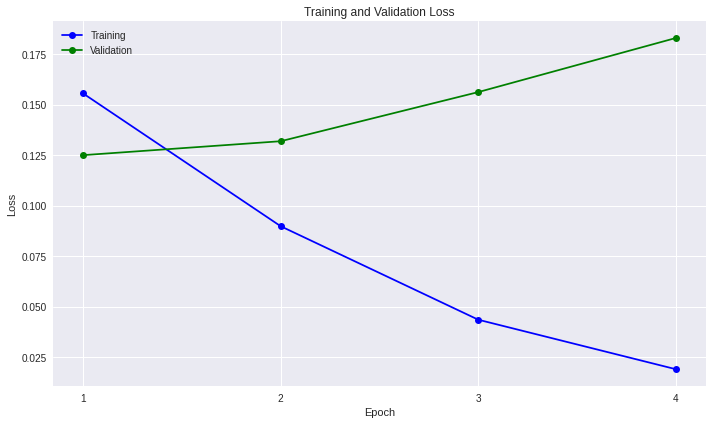

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Training and Validation Loss")
ax.plot(df_stats['Training Loss'], 'b-o', label='Training')
ax.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_xticks(np.arange(1, 5, 1))
plt.tight_layout()

In [ ]:
df_stats

,Training Loss,Valid. Loss,Valid. Acc,Valid. F1,Valid. Precision,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,
1,0.155519,0.124961,0.951442,0.621723,0.706383,0.555184,0:13:13,0:00:43
2,0.089756,0.131856,0.956250,0.693603,0.698305,0.688963,0:13:11,0:00:33
3,0.043456,0.156193,0.961538,0.726027,0.743860,0.709030,0:13:06,0:00:33
4,0.018946,0.182983,0.964663,0.745234,0.773381,0.719064,0:13:03,0:00:33


Some of the concluisions we can extract from the previous descriptive metrics we have obtained from this bunch of performance metrics and plots are the following:


*   After first epoch, the model starts to overfit notoriously. This can be depicted from the Training/Validation Loss plot.
*   In the second epoch, recall value experiments a considerably change.
* Third and fourth epoch have quite similar results. In both of them, the overfitting problem is significant, nonetheless, classification report values of F1/Precision/Recall are better than the previous two epochs. This is not casual, because the dataset, as we have noticed in the exploratory analysis, is deeply unbalanced, having far more samples standing for `not-claim` than for `claim`. This is the typical case where, if we create a toy model that only predicts `not-claim` labels, it would obtain a 99% of accuracy.
* In the fourth epoch is where we obtained the best result in terms of avoiding False Negatives (FN) predictions.

My decision is to retrain the model with the whole trainingset (train+validation) for 4 epochs, because, despite of knowing that the model is overfitted, taking into acount that our first goal is to overweight the Recall metric, and avoiding that true `claim` would be missclassified as `not-claim` and not having the chance of analyze them in a verification process. The opposite case is not so bad, because if we predict a `not-claim` sample as `claim`, we will be able to discard it in the subsequent process.



In [ ]:
trainset_all = ConcatDataset([trainset, valset])
train_generator_all = DataLoader(dataset=trainset_all, 
                                 batch_size=batch_size, 
                                 sampler = RandomSampler(trainset_all))

In [ ]:
# Instantiate BertTrainValidateTest class for helping us with the construction of the model and its evaluation
bert_clf = BertTrainValidateTest(batch_size=batch_size, 
                                 learning_rate=lr, 
                                 epochs=4)
# Load pre-trained model for fine-tuning it (Reinitialize the pre-trained model we have modified before)
model = bert_clf.load_pretrained_model(model_class=BertForSequenceClassification,  
                                       model_name="bert-base-multilingual-cased", 
                                       num_labels=2, 
                                       output_attentions=False, 
                                       output_hidden_states=False, 
                                       fine_tune='all')
# Fix seed value for reproducible results
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
model, training_stats = bert_clf.train(train_generator=train_generator, 
                                       val_generator=None)


-> Epoch 1 / 4
Training...
  Batch   100  of  1,040.    Elapsed: 0:01:17.
  Batch   200  of  1,040.    Elapsed: 0:02:33.
  Batch   300  of  1,040.    Elapsed: 0:03:49.
  Batch   400  of  1,040.    Elapsed: 0:05:06.
  Batch   500  of  1,040.    Elapsed: 0:06:22.
  Batch   600  of  1,040.    Elapsed: 0:07:38.
  Batch   700  of  1,040.    Elapsed: 0:08:54.
  Batch   800  of  1,040.    Elapsed: 0:10:10.
  Batch   900  of  1,040.    Elapsed: 0:11:27.
  Batch 1,000  of  1,040.    Elapsed: 0:12:43.
  
Average training loss: 0.15
  Training epcoh took: 0:13:13

-> Epoch 2 / 4
Training...
  Batch   100  of  1,040.    Elapsed: 0:01:16.
  Batch   200  of  1,040.    Elapsed: 0:02:32.
  Batch   300  of  1,040.    Elapsed: 0:03:48.
  Batch   400  of  1,040.    Elapsed: 0:05:05.
  Batch   500  of  1,040.    Elapsed: 0:06:21.
  Batch   600  of  1,040.    Elapsed: 0:07:37.
  Batch   700  of  1,040.    Elapsed: 0:08:53.
  Batch   800  of  1,040.    Elapsed: 0:10:09.
  Batch   900  of  1,040.    Elapsed

In [ ]:
torch.save(model, 
           'drive/My Drive/Colab Notebooks/best-model.pt')
torch.save(model.state_dict(), 
           'drive/My Drive/Colab Notebooks/best-model-parameters.pt')

## Evaluate model 1: Multilingual BERT for Sequence Classification fine-tuning

In [ ]:
# Define an iterator for efficiently streaming batches of data for training the model
test_generator = DataLoader(dataset=testset,  
                            batch_size=batch_size, 
                            sampler=SequentialSampler(testset))

In [ ]:
predictions, true_labels = bert_clf.test(test_generator)


Predicting unseen samples...
Test_acc: 0.9644230769230769, Test_F1: 0.7430555555555557, Test_precision: 0.7725631768953068, Test_recall: 0.7157190635451505
  Test took: 0:00:33


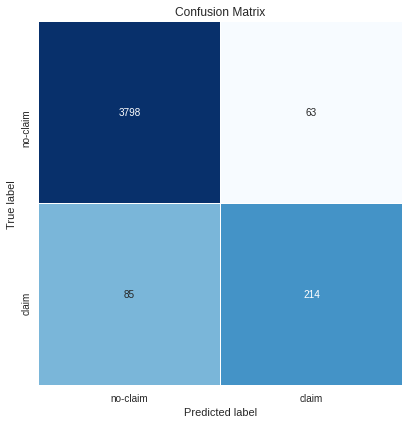

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true=np.array(true_labels).flatten(), y_pred=np.array(predictions).flatten())
df_cm = pd.DataFrame(cm, index=[[l for l in ['no-claim', 'claim']]],
                      columns=[[l for l in ['no-claim', 'claim']]])
f, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Confusion Matrix")
cm_plot = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False,
                      square=True, ax=ax, norm=PowerNorm(gamma=0.15))
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

In [ ]:
report_csv_multi_bert = pd.DataFrame(columns=['sentence', 'claim_ground_truth', 'claim_prediction'])
report_csv_multi_bert['sentence'] = test_text['text']
report_csv_multi_bert['claim_ground_truth'] = test_text['claim']
report_csv_multi_bert['claim_prediction'] = np.array(predictions).flatten()

In [ ]:
report_csv_multi_bert.to_csv('drive/My Drive/Colab Notebooks/report_csv_multi_bert.csv', index=False, encoding='utf8')

## Define and Train model 2: Multilingual Universal Sentence Encoder fine-tuning (only classification layer)

In order to use other architecture different than Transformers, we are going to use in this case a Universal Sentence Encoder implementing a CNN encoder. This will allow us to train faster. Let's check if the improvement in computing time is worth it with regard to the final performance quality.

This time, we are going to leave the pre-trained model as is, and add a head layer (fully-connected dense layer) on top of it to only tune these weights and suit the model to our classification problem.

The decision of not training all the available parameters of the pre-trained model, maybe would lead us not to fall again in the overfitting problem, because training only the last decision layer, do not need very large datasets to achieve model properly all trainable parameters.

In [44]:
def build_model(model_url, num_labels):
  """ Simple model that receives text input as string and embed it with the MUSE 
  embedding layer. After that a simple fully-connected layer is implemented for 
  further processing and eventually a sigmoid layer is added for decision-taking. 
  """
  input_layer = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
  embedding_layer = hub.KerasLayer(model_url, trainable=False)(tf.squeeze(tf.cast(input_layer, tf.string)))
  layer_norm = tf.keras.layers.BatchNormalization()(embedding_layer)
  layer_dropout = tf.keras.layers.Dropout(0.4)(layer_norm)
  hidden_layer = tf.keras.layers.Dense(units=512, activation='relu')(embedding_layer)
  layer_norm = tf.keras.layers.BatchNormalization()(hidden_layer)
  layer_dropout = tf.keras.layers.Dropout(0.4)(layer_norm)
  output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(hidden_layer)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  return model

In [45]:
model = build_model(model_url='https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 
                    num_labels=2)

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
tf.cast_1 (TFOpLambda)       (None, 1)                 0         
_________________________________________________________________
tf.compat.v1.squeeze_1 (TFOp None                      0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 512)               68927232  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 69,190,401
Trainable params: 263,169
Non-trainable params: 68,927,232
_________________________________________

In [43]:
# Performance metrics to pass to the model for tracking its improvent by epoch
def recall(y_true,
           y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TPandFN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TPandFN + K.epsilon())


def precision(y_true, 
              y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TPandFP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TPandFP + K.epsilon())


def f1(y_true,
       y_pred):
    r = recall(y_true, y_pred)
    p = precision(y_true, y_pred)
    return 2*((p*r) / (p+r+K.epsilon()))

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1, precision, recall])

In [48]:
# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='drive/MyDrive/ColabNotebooks/claim_check_worthiness/best-model.hdf5', 
                                                  verbose=True, 
                                                  save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3, 
                                                restore_best_weights=True)
myCallbacks = [checkpointer, earlystopper]

In [114]:
ohe = OneHotEncoder(categories='auto', sparse=False)
y_train = ohe.fit_transform(train_text['claim'].values.reshape(-1, 1))
y_val = ohe.transform(val_text['claim'].values.reshape(-1,1))

In [29]:
train_text['claim'].values.reshape(-1, 1)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [49]:
epochs = 20
batch_size = 64

In [50]:
# Fix seed value for reproducible results
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [51]:
model.fit(x=train_text['text'].values, 
          y=train_text['claim'].values.reshape(-1, 1).astype('float32'), 
          validation_data=(val_text['text'].values, val_text['claim'].values.reshape(-1,1).astype('float32')),
          epochs=epochs, 
          batch_size=batch_size, 
          shuffle=True, 
          callbacks=myCallbacks)

Epoch 1/20
520/520 [==============================] - 14s 18ms/step - loss: 0.2454 - accuracy: 0.9218 - f1: 0.1390 - precision: 0.2298 - recall: 0.1181 - val_loss: 0.1516 - val_accuracy: 0.9409 - val_f1: 0.3871 - val_precision: 0.5967 - val_recall: 0.3131

Epoch 00001: val_loss improved from inf to 0.15157, saving model to drive/MyDrive/ColabNotebooks/claim_check_worthiness/best-model.hdf5
Epoch 2/20
520/520 [==============================] - 8s 16ms/step - loss: 0.1349 - accuracy: 0.9494 - f1: 0.5035 - precision: 0.7172 - recall: 0.4270 - val_loss: 0.1427 - val_accuracy: 0.9433 - val_f1: 0.4149 - val_precision: 0.6300 - val_recall: 0.3318

Epoch 00002: val_loss improved from 0.15157 to 0.14274, saving model to drive/MyDrive/ColabNotebooks/claim_check_worthiness/best-model.hdf5
Epoch 3/20
520/520 [==============================] - 8s 16ms/step - loss: 0.1120 - accuracy: 0.9590 - f1: 0.6198 - precision: 0.8186 - recall: 0.5348 - val_loss: 0.1235 - val_accuracy: 0.9502 - val_f1: 0.5576 -

In [52]:
history = model.history

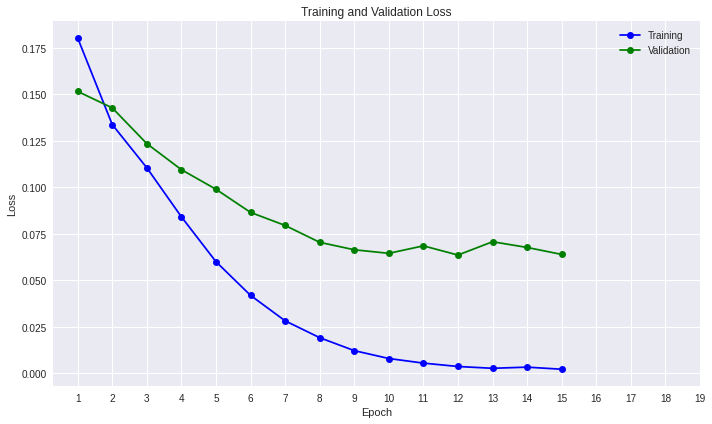

In [53]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Training and Validation Loss")
ax.plot(np.arange(1, 16, 1), history.history['loss'], 'b-o', label='Training')
ax.plot(np.arange(1, 16, 1), history.history['val_loss'], 'g-o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_xticks(np.arange(1, epochs, 1))
plt.tight_layout()

In [54]:
df_stats = pd.DataFrame({"Training Loss": history.history['loss'],	
                         "Valid. Loss": history.history['val_loss'],	
                         "Valid. Acc": history.history['val_accuracy'],	
                        #  "Valid. F1": history.history['val_f1'],	
                         "Valid. Precision": history.history['val_precision'],	
                         "Valid. Recall": history.history['val_recall']})
df_stats.index.names = ['Epoch']
df_stats.index = np.arange(1, 16, 1)

In [55]:
df_stats

,Training Loss,Valid. Loss,Valid. Acc,Valid. Precision,Valid. Recall
1,0.180297,0.151569,0.940865,0.596667,0.313095
2,0.133782,0.142738,0.943269,0.630000,0.331764
3,0.110536,0.123513,0.950240,0.700110,0.500916
4,0.084184,0.109518,0.957933,0.806520,0.498633
5,0.060062,0.098994,0.962740,0.805183,0.586386
6,0.041966,0.086557,0.968990,0.838718,0.669548
7,0.028277,0.079534,0.968750,0.832363,0.650000
8,0.019215,0.070471,0.973798,0.849725,0.771972
9,0.012254,0.066457,0.975962,0.896520,0.721593
10,0.008015,0.064547,0.976683,0.883956,0.751038


This time the overfitting is not so explicit like before. Depite of also being overfitting since second epoch, this time at least, we can observe that validation loss curve continues decaying until the 8th epoch, meaning that the model was still being able to learn new features of the unseen data, in other words, being more able to generalize.

From the 9th epoch in advance, validation loss gets stacked. 

However, looking to the classification report metrics, we can be happy because we have obtained now much better results than the ones obtained fine-tuning multilingual BERT. So this pre-trained model seems to capture more robustly nuaces in semantics than multilingual BERT does.

## Evaluate model 2: Multilingual Universal Sentence Encoder fine-tuning (only classification layer)

In [ ]:
y_test = ohe.transform(test_text['claim'].values.reshape(-1,1))

In [56]:
metrics = model.evaluate(x=test_text['text'].values, 
                         y=test_text['claim'].values.reshape(-1,1).astype('float32'), 
                         batch_size=64)
print(f"Test Loss: {metrics[0]}, Test_acc: {metrics[1]}, Test_F1: {metrics[2]}, Test_precision: {metrics[3]}, Test_recall: {metrics[4]}")

65/65 [==============================] - 1s 14ms/step - loss: 0.0638 - accuracy: 0.9791 - f1: 0.8259 - precision: 0.9151 - recall: 0.7879
Test Loss: 0.06381001323461533, Test_acc: 0.9790865182876587, Test_F1: 0.8258501291275024, Test_precision: 0.9150548577308655, Test_recall: 0.787899911403656


In [63]:
pred_probs = model.predict(x=test_text['text'].values, 
                           batch_size=64)
# y_pred = np.argmax(pred_probs, axis=1)
y_pred = [0 if i < 0.5 else 1 for i in pred_probs]

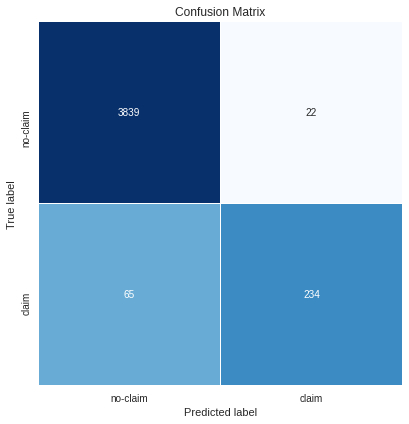

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_true=np.float32(test_text['claim'].values), y_pred=y_pred)
df_cm = pd.DataFrame(cm, index=[[l for l in ['no-claim', 'claim']]],
                      columns=[[l for l in ['no-claim', 'claim']]])
f, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Confusion Matrix")
cm_plot = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False,
                      square=True, ax=ax, norm=PowerNorm(gamma=0.15))
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.tight_layout()

In [65]:
report_csv_muse = pd.DataFrame(columns=['sentence', 'claim_ground_truth', 'claim_prediction'])
report_csv_muse['sentence'] = test_text['text']
report_csv_muse['claim_ground_truth'] = test_text['claim']
report_csv_muse['claim_prediction'] = y_pred

In [66]:
report_csv_muse.to_csv('drive/MyDrive/ColabNotebooks/claim_check_worthiness/report_muse.csv', index=False, encoding='utf8')

## Comparison analysis

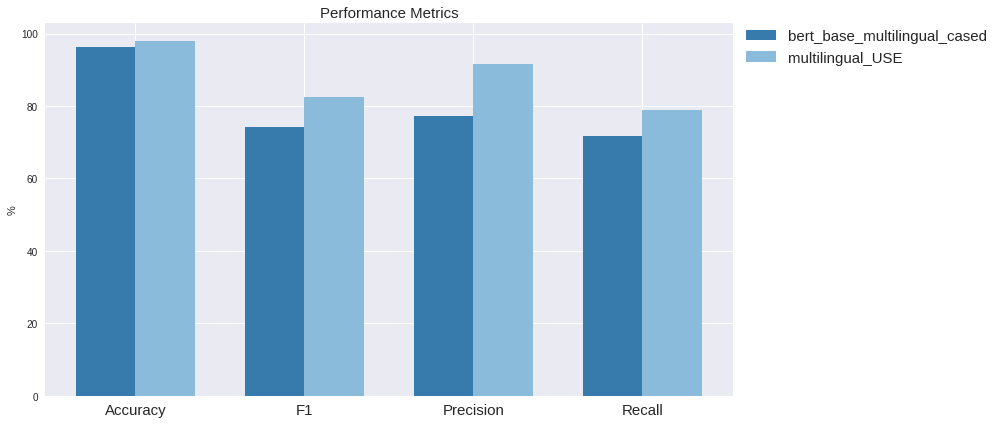

In [67]:
bert_base_multilingual_cased = [0.964, 0.743, 0.773, 0.716]
multilingual_USE = [0.979, 0.826, 0.915, 0.788]

ind = np.arange(4) 
width = 0.35    
f, ax = plt.subplots(figsize=(14, 6))   
ax.bar(ind, bert_base_multilingual_cased, width, label='bert_base_multilingual_cased', color=sns.color_palette("Blues_d")[3])
ax.bar(ind + width, multilingual_USE, width,
    label='multilingual_USE', color=sns.color_palette("Blues_d")[0])

ax.set_ylabel('%')
ax.set_title('Performance Metrics', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Accuracy', 'F1', 'Precision', 'Recall'), fontsize=15)
ax.set_yticklabels(('0', '20', '40', '60', '80', '100'))
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15)
plt.tight_layout()